<a href="https://colab.research.google.com/github/jhenningsen/Equity_Analysis/blob/main/LangStudio/RSI_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [7]:
# --- 1. Configuration & Symbol Loading ---
RSI_LEVELS = [25, 30, 35, 40]
RSI_LENGTHS = [3, 5, 7, 10, 12, 14, 16, 18, 22, 24, 26]

# Load Symbols from your OptionVolume.csv
try:
    df_csv = pd.read_csv("OptionVolume.csv")
    # Ensuring we handle different possible column names for Symbol
    symbol_col = [c for c in df_csv.columns if 'symbol' in c.lower()][0]
    SYMBOLS = df_csv[symbol_col].str.strip().unique().tolist()
    print(f"Loaded {len(SYMBOLS)} symbols from OptionVolume.csv")
except Exception as e:
    print(f"Could not load CSV: {e}. Falling back to default list.")
    SYMBOLS = ["TSLA", "SPY", "QQQ", "NVDA", "AAPL", "MSFT"]

# --- 2. Enhanced RSI Function (Wilder's Smoothing) ---
def calculate_rsi_yahoo(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# --- 3. Data Fetching & Vectorized Math ---
print("Fetching data and calculating vectorized returns...")
data_cache = {}
for s in SYMBOLS:
    try:
        df = yf.download(s, period="5y", interval="1d", progress=False, auto_adjust=True)
        if df.empty: continue
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        # VECTORIZED RETURN CALCULATION
        # Calculate percentage change and shift it backward to see future results
        df['Ret_3D'] = df['Close'].pct_change(3).shift(-3)
        df['Ret_5D'] = df['Close'].pct_change(5).shift(-5)
        df['Ret_10D'] = df['Close'].pct_change(10).shift(-10)

        data_cache[s] = df
    except:
        continue

# --- 4. Parameter Sweep ---
all_results = []

for rsi_len in RSI_LENGTHS:
    for rsi_thresh in RSI_LEVELS:
        param_trades = []

        for symbol, df_orig in data_cache.items():
            df = df_orig.copy()
            df['RSI'] = calculate_rsi_yahoo(df['Close'], period=rsi_len)

            # Filter for signal
            trades = df[df['RSI'] < rsi_thresh].dropna(subset=['RSI', 'Ret_10D']).copy()

            if not trades.empty:
                trades['RSI_Len'] = rsi_len
                trades['RSI_Thresh'] = rsi_thresh
                trades['Symbol'] = symbol
                param_trades.append(trades)

        if param_trades:
            combined = pd.concat(param_trades)
            all_results.append({
                "RSI_Len": rsi_len,
                "RSI_Thresh": rsi_thresh,
                "Avg_3D": combined['Ret_3D'].mean(),
                "Avg_5D": combined['Ret_5D'].mean(),
                "Avg_10D": combined['Ret_10D'].mean(),
                "Win_Rate_3D": (combined['Ret_3D'] > 0).mean(),
                "Win_Rate_5D": (combined['Ret_5D'] > 0).mean(),
                "Win_Rate_10D": (combined['Ret_10D'] > 0).mean(),
                "Trade_Count": len(combined)
            })

# --- 5. Summary Display ---
if all_results:
    summary_df = pd.DataFrame(all_results)
    # Sorting by 5D return as it's been our benchmark
    summary_df = summary_df.sort_values(by="Avg_5D", ascending=False)

    print("\n--- FULL LIST VECTORIZED OPTIMIZATION SUMMARY ---")
    display(summary_df)
    summary_df.to_csv("vectorized_rsi_results.csv", index=False)
else:
    print("No trades found across the symbol list.")

Loaded 50 symbols from OptionVolume.csv
Fetching data and calculating vectorized returns...

--- FULL LIST VECTORIZED OPTIMIZATION SUMMARY ---


,RSI_Len,RSI_Thresh,Avg_3D,Avg_5D,Avg_10D,Win_Rate_3D,Win_Rate_5D,Win_Rate_10D,Trade_Count
20,14,25,0.070013,0.140565,0.071129,0.618143,0.675105,0.677215,474
16,12,25,0.051273,0.112585,0.077455,0.579531,0.635018,0.653514,811
12,10,25,0.031672,0.074663,0.084617,0.563509,0.618947,0.635789,1425
40,26,25,0.056616,0.066569,0.043840,0.750000,0.812500,0.750000,16
21,14,30,0.026630,0.050568,0.033619,0.570449,0.610349,0.625312,1604
36,24,25,0.054987,0.049422,0.034797,0.782609,0.782609,0.695652,23
17,12,30,0.023048,0.047666,0.037280,0.558248,0.604167,0.617772,2352
32,22,25,0.047726,0.044103,0.018720,0.720930,0.697674,0.581395,43
28,18,25,0.038501,0.040679,0.036894,0.653333,0.686667,0.646667,150
13,10,30,0.016726,0.036395,0.043564,0.542363,0.576657,0.602594,3470


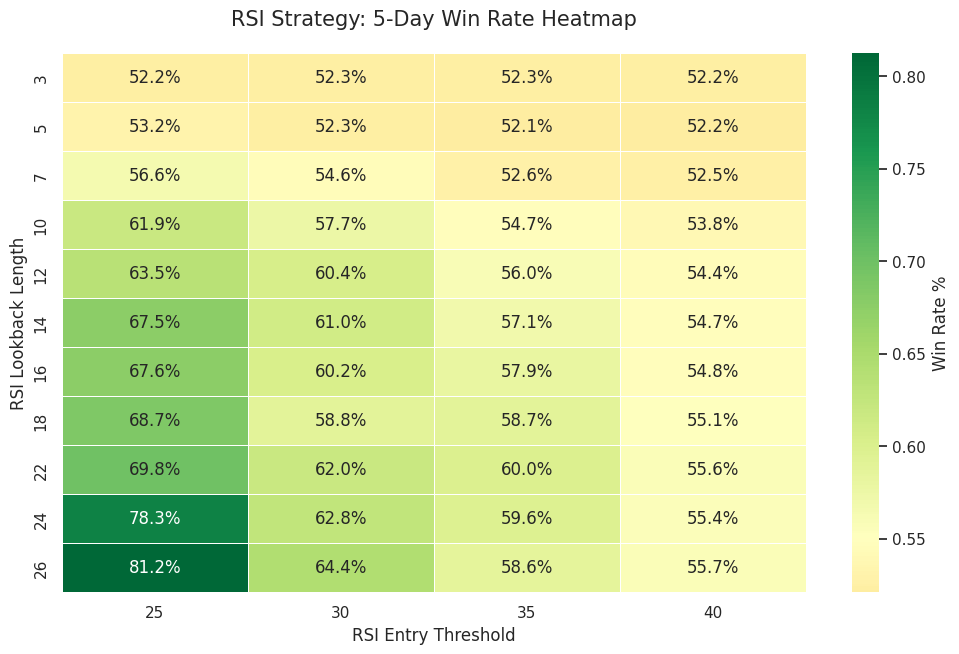

In [8]:
# 1. Pivot the data
heatmap_data = summary_df.pivot(index="RSI_Len", columns="RSI_Thresh", values="Win_Rate_5D")

# 2. Set up the figure
plt.figure(figsize=(12, 7))

# 3. Create the heatmap with optimized gradient parameters
# vmin/vmax: forces the color scale to start/end at your actual data's min/max
# center: set this to 0.5 (break even) or 0.55 to show what's "above average"
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1%",
    cmap="RdYlGn",
    vmin=summary_df["Win_Rate_5D"].min(),
    vmax=summary_df["Win_Rate_5D"].max(),
    center=0.55,
    linewidths=.5,
    cbar_kws={'label': 'Win Rate %'}
)

# 4. Labels
plt.title("RSI Strategy: 5-Day Win Rate Heatmap", fontsize=15, pad=20)
plt.xlabel("RSI Entry Threshold", fontsize=12)
plt.ylabel("RSI Lookback Length", fontsize=12)

plt.show()

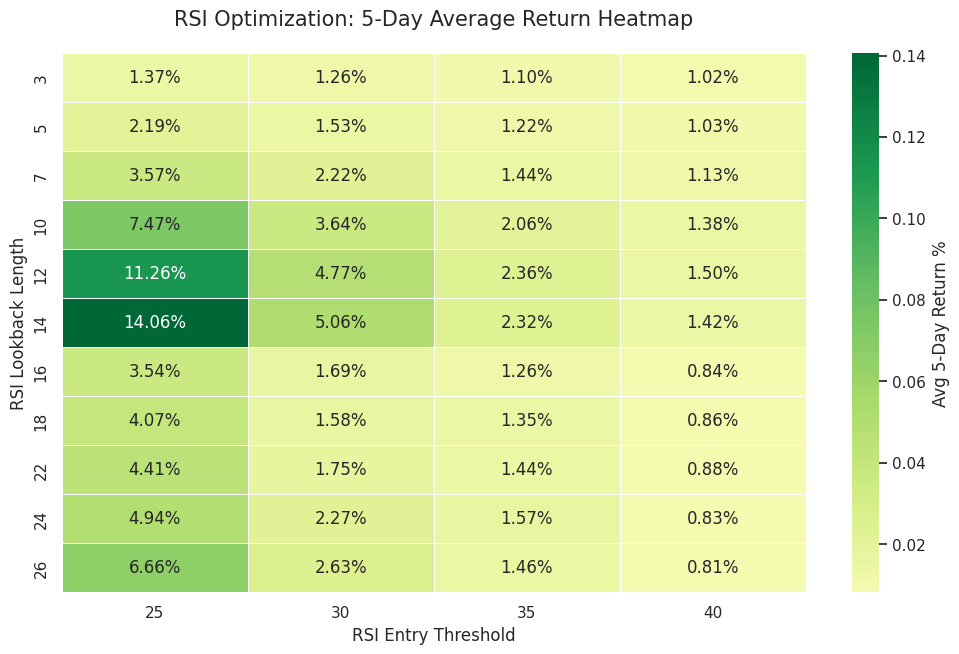

In [10]:
# 1. Pivot the data for Average 5-Day Return
heatmap_data = summary_df.pivot(index="RSI_Len", columns="RSI_Thresh", values="Avg_5D")

# 2. Set up the figure
plt.figure(figsize=(12, 7))
sns.set_theme(style="white")

# 3. Create the heatmap with optimized gradient parameters
# vmin/vmax: Stretches the color range to your specific best and worst performers
# center=0: Ensures the color transition happens exactly at the break-even point
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2%",
    cmap="RdYlGn",
    vmin=summary_df["Avg_5D"].min(),
    vmax=summary_df["Avg_5D"].max(),
    center=0,
    linewidths=.5,
    cbar_kws={'label': 'Avg 5-Day Return %'}
)

# 4. Labels and Title
plt.title("RSI Optimization: 5-Day Average Return Heatmap", fontsize=15, pad=20)
plt.xlabel("RSI Entry Threshold", fontsize=12)
plt.ylabel("RSI Lookback Length", fontsize=12)

plt.show()

## 2022 Back test

In [11]:
# --- 1. Configuration & Symbol Loading ---
RSI_LEVELS = [25, 30, 35, 40]
RSI_LENGTHS = [7, 10, 12, 14, 16, 18, 20, 22, 24, 26]

# Data window to capture all of 2022 with buffers for indicators and returns
START_DATE = "2021-11-01"
END_DATE = "2023-01-20"

try:
    df_csv = pd.read_csv("OptionVolume.csv")
    symbol_col = [c for c in df_csv.columns if 'symbol' in c.lower()][0]
    SYMBOLS = df_csv[symbol_col].str.strip().unique().tolist()
    print(f"Loaded {len(SYMBOLS)} symbols from OptionVolume.csv")
except Exception as e:
    print(f"Could not load CSV: {e}. Falling back to default list.")
    SYMBOLS = ["TSLA", "SPY", "QQQ", "NVDA", "AAPL", "MSFT", "AMD", "META"]

# --- 2. Yahoo-Style RSI Function ---
def calculate_rsi_yahoo(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Wilder's Smoothing logic
    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# --- 3. Data Fetching & Vectorized Math ---
print(f"Fetching data from {START_DATE} to {END_DATE}...")
data_cache = {}
for s in SYMBOLS:
    try:
        df = yf.download(s, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)
        if df.empty: continue
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        # Vectorized Future Returns (Shifted backwards)
        df['Ret_3D'] = df['Close'].pct_change(3).shift(-3)
        df['Ret_5D'] = df['Close'].pct_change(5).shift(-5)
        df['Ret_10D'] = df['Close'].pct_change(10).shift(-10)

        data_cache[s] = df
    except:
        continue

# --- 4. Parameter Sweep for 2022 ---
all_results = []

print("Running 2022 Analysis...")
for rsi_len in RSI_LENGTHS:
    for rsi_thresh in RSI_LEVELS:
        param_trades = []

        for symbol, df_orig in data_cache.items():
            df = df_orig.copy()
            df['RSI'] = calculate_rsi_yahoo(df['Close'], period=rsi_len)

            # --- CRITICAL FILTER: Only include signals that triggered in 2022 ---
            mask_2022 = (df.index >= "2022-01-01") & (df.index <= "2022-12-31")
            trades = df[mask_2022 & (df['RSI'] < rsi_thresh)].dropna(subset=['RSI', 'Ret_10D']).copy()

            if not trades.empty:
                trades['RSI_Len'] = rsi_len
                trades['RSI_Thresh'] = rsi_thresh
                trades['Symbol'] = symbol
                param_trades.append(trades)

        if param_trades:
            combined = pd.concat(param_trades)
            all_results.append({
                "RSI_Len": rsi_len,
                "RSI_Thresh": rsi_thresh,
                "Avg_3D": combined['Ret_3D'].mean(),
                "Avg_5D": combined['Ret_5D'].mean(),
                "Avg_10D": combined['Ret_10D'].mean(),
                "Win_Rate_3D": (combined['Ret_3D'] > 0).mean(),
                "Win_Rate_5D": (combined['Ret_5D'] > 0).mean(),
                "Win_Rate_10D": (combined['Ret_10D'] > 0).mean(),
                "Trade_Count": len(combined)
            })

# --- 5. Summary Table ---
if all_results:
    summary_df_2022 = pd.DataFrame(all_results)
    summary_df_2022 = summary_df_2022.sort_values(by="Avg_5D", ascending=False)

    print("\n--- 2022 RSI BACKTEST SUMMARY ---")
    display(summary_df_2022)
    summary_df_2022.to_csv("rsi_results_2022.csv", index=False)
else:
    print("No trades triggered in 2022 with current parameters.")

Loaded 50 symbols from OptionVolume.csv
Fetching data from 2021-11-01 to 2023-01-20...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CRWV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-11-01 -> 2023-01-20) (Yahoo error = "Data doesn\'t exist for startDate = 1635739200, endDate = 1674190800")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IBIT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-11-01 -> 2023-01-20) (Yahoo error = "Data doesn\'t exist for startDate = 1635739200, endDate = 1674190800")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WOLF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-11-01 -> 2023-01-20) (Yahoo error = "Data doesn\'t exist for startDate = 1635739200, endDate = 1674190800")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CRCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-11-01 -> 2023-01-20) (Yahoo error = "Data doesn\'t exist for startDate = 1635739200, endDate = 1674190800")')
ERROR:yfinance:
1 Failed download:
E

Running 2022 Analysis...

--- 2022 RSI BACKTEST SUMMARY ---


,RSI_Len,RSI_Thresh,Avg_3D,Avg_5D,Avg_10D,Win_Rate_3D,Win_Rate_5D,Win_Rate_10D,Trade_Count
36,26,25,0.042563,0.031416,0.041874,0.583333,0.750000,0.666667,24
32,24,25,0.039804,0.027608,0.036755,0.571429,0.714286,0.642857,28
28,22,25,0.026089,0.022864,0.033956,0.564103,0.692308,0.641026,39
16,16,25,0.021520,0.019486,0.025673,0.511111,0.577778,0.614815,135
24,20,25,0.030521,0.019208,0.032522,0.581818,0.636364,0.654545,55
12,14,25,0.017398,0.018792,0.022842,0.525822,0.605634,0.615023,213
20,18,25,0.019984,0.016885,0.018441,0.495238,0.580952,0.609524,105
8,12,25,0.013127,0.011782,0.019755,0.501529,0.556575,0.599388,327
4,10,25,0.009689,0.011176,0.010244,0.500971,0.572816,0.565049,515
38,26,35,0.007646,0.011051,0.011011,0.484396,0.545455,0.563094,737


In [21]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta

# --- 1. Configuration ---
RSI_LEVELS = [25, 30]
RSI_LENGTHS = [10, 12, 14, 16, 18, 20, 22, 24, 26]
SMA_PERIODS = [50, 100, 150, 200]

try:
    df_csv = pd.read_csv("OptionVolume.csv")
    symbol_col = [c for c in df_csv.columns if 'symbol' in c.lower()][0]
    SYMBOLS = df_csv[symbol_col].str.strip().unique().tolist()
    print(f"Loaded {len(SYMBOLS)} symbols from OptionVolume.csv")
except Exception as e:
    print(f"Could not load CSV: {e}. Falling back to default list.")
    SYMBOLS = ["TSLA", "SPY", "QQQ", "NVDA", "AAPL", "MSFT", "AMD", "META"]

# --- 2. Precision RSI (Wilder's Smoothing) ---
def calculate_rsi_yahoo(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# --- 3. Data Fetching & Vectorized Calculation ---
print("Fetching 7 years of data (providing 2-year warm-up for SMAs)...")
data_cache = {}
study_start_date = datetime.now() - timedelta(days=5*365)

for s in SYMBOLS:
    try:
        df = yf.download(s, period="7y", interval="1d", progress=False, auto_adjust=True)
        if df.empty or len(df) < 250: continue

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        df['Ret_5D'] = df['Close'].pct_change(5).shift(-5)

        for sma in SMA_PERIODS:
            df[f'SMA_{sma}'] = df['Close'].rolling(window=sma).mean()
            df[f'Above_SMA_{sma}'] = df['Close'] > df[f'SMA_{sma}']

        df = df.loc[df.index >= study_start_date].copy()
        data_cache[s] = df
    except:
        continue

# --- 4. Backtest Sweep ---
all_results = []

for rsi_len in RSI_LENGTHS:
    for rsi_thresh in RSI_LEVELS:
        param_trades = []

        for symbol, df_orig in data_cache.items():
            df = df_orig.copy()
            df['RSI'] = calculate_rsi_yahoo(df['Close'], period=rsi_len)

            trades = df[df['RSI'] < rsi_thresh].dropna(subset=['RSI', 'Ret_5D']).copy()
            if not trades.empty:
                trades['RSI_Len'] = rsi_len
                trades['RSI_Thresh'] = rsi_thresh
                param_trades.append(trades)

        if param_trades:
            combined = pd.concat(param_trades)

            res = {
                "RSI_Len": rsi_len,
                "RSI_Thresh": rsi_thresh,
                "Trades": len(combined),
                "WR_All": (combined['Ret_5D'] > 0).mean()
            }

            for sma in SMA_PERIODS:
                above_df = combined[combined[f'Above_SMA_{sma}'] == True]
                below_df = combined[combined[f'Above_SMA_{sma}'] == False]

                # Above Stats
                res[f'WR_Above_{sma}'] = (above_df['Ret_5D'] > 0).mean() if len(above_df) > 0 else np.nan
                res[f'Cnt_Above_{sma}'] = len(above_df)

                # Below Stats
                res[f'WR_Below_{sma}'] = (below_df['Ret_5D'] > 0).mean() if len(below_df) > 0 else np.nan
                res[f'Cnt_Below_{sma}'] = len(below_df)

            all_results.append(res)

# --- 5. Summary Display ---
if all_results:
    summary_df = pd.DataFrame(all_results)
    summary_df = summary_df.sort_values(by="WR_All", ascending=False)

    # Building the display list dynamically
    display_cols = ["RSI_Len", "RSI_Thresh", "Trades", "WR_All"]
    for sma in SMA_PERIODS:
        display_cols.extend([f"WR_Above_{sma}", f"Cnt_Above_{sma}", f"WR_Below_{sma}", f"Cnt_Below_{sma}"])

    print("\n" + "="*200)
    print("WIN RATE & COUNT COMPARISON: ABOVE VS BELOW SMA TRENDLINES (5-Day Forward Return)")
    print("="*200)

    # Optimized print for wide tables
    print(summary_df[display_cols].to_string(
        index=False,
        float_format=lambda x: f"{x:.1%}" if isinstance(x, (float, np.float64)) and 0 <= x <= 1 else f"{int(x)}" if isinstance(x, (float, np.float64)) and x > 1 else str(x),
        na_rep="N/A"
    ))
    print("="*200)

    summary_df.to_csv("rsi_complete_trend_results_with_counts.csv", index=False)
else:
    print("No trades found.")

Loaded 50 symbols from OptionVolume.csv
Fetching 7 years of data (providing 2-year warm-up for SMAs)...

WIN RATE & COUNT COMPARISON: ABOVE VS BELOW SMA TRENDLINES (5-Day Forward Return)
 RSI_Len  RSI_Thresh  Trades  WR_All  WR_Above_50  Cnt_Above_50  WR_Below_50  Cnt_Below_50  WR_Above_100  Cnt_Above_100  WR_Below_100  Cnt_Below_100  WR_Above_150  Cnt_Above_150  WR_Below_150  Cnt_Below_150  WR_Above_200  Cnt_Above_200  WR_Below_200  Cnt_Below_200
      26          25      17   82.4%          N/A             0        82.4%            17           N/A              0         82.4%             17           N/A              0         82.4%             17           N/A              0         82.4%             17
      24          25      26   76.9%          N/A             0        76.9%            26           N/A              0         76.9%             26           N/A              0         76.9%             26           N/A              0         76.9%             26
      20          